In [48]:
import numpy as np

class Load(object):
    """
    The parent class 'Load' defines several basic functions used in all load
    cases. The load and boundary conditions thus can be determined using the
    functions defined in this parent class.
    
    Parameters
    ----------
    nelx : int
        Number of elements in x direction.
    nely : int
        Number of elements in y direction.
    E : float
        Young's modulus of the material.
    nu : float
        Poisson ratio of the material.
    
    Attributes
    ----------
    nelx : int
        Number of elements in x direction.
    nely : int
        Number of elements in y direction.
    E : float
        Young's modulus of the material.
    nu : float
        Poisson ratio of the material.
    dim : int
        Amount of dimensions considered in the problem.
        In 2-D cases, dim is set to 2.
    """
    def __init__(self, nelx, nely, E, nu):
        self.nelx = nelx
        self.nely = nely
        self.E = E
        self.nu = nu
        self.dim = 2

    def node(self, elx, ely):
        """
        Calculates the topleft node number of the requested element.
        Computes 1D index from 2D position for node (boundary of elment).

        Element coordinate Direction: --------> x
                                      |
                                      |
                                      |
                                      v
                                      y

        Parameters
        ----------
        elx : int
            X position of the requested element.
        ely : int
            Y position of the requested element.

        Returns
        -------
        topleft : int
            The node number of the top left node.
        """
        return (self.nely + 1) * elx + ely

    def nodes(self, elx, ely):
        """
        Calcutes all node nubers of the requested element.

        Example : -----n1---------n2-----
                        |(elx,ely)|
                  -----n4---------n3-----
        Nodes coordinate direction: from top left to top bottom,
                                    from left to right.

            0 n+1 2n+2 ...
            1
            ...
            n
        Parameters
        ----------
        elx : int
            X position of the requested element.
        ely : int
            Y position of the requested element.

        Returns
        -------
        n1 : int
            The node number of the top left node.
        n2 : int
            The node number of the top right node.
        n3 : int
            The node number of the bottom right node.
        n4 : int
            The node number of the bottom left node.
        """
        n1 = self.node(elx    , ely    )
        n2 = self.node(elx + 1, ely    )
        n3 = self.node(elx + 1, ely + 1)
        n4 = self.node(elx    , ely + 1)
        return n1, n2, n3, n4

    def edof(self):
        """
        Generates an array with the position of the nodes of each element
        in the global stiiffness matrix.

        The element counting direction : the same as the nodes

            E(1) E(n+1)...
            E(2)
            ..
            E(n)

        Returns
        -------
        edof : 2-D array size(nelx * nely, 8)
            The list with all elements and their degree of freedom numbers.
        x_list : 1-D array len(nelx * nely * 8 * 8)
            The list with the x indices of all elements to be inserted into
            the global stiffness matrix.
        y_list : 1-D array len(nelx * nely * 8 * 8)
            The list with the y indices of all elements to be inserted into
            the global stiffness matrix.

        Process viarables
        -----------------
        elx : 2-D array size(nelx * nely, 1)
            The list with the x position of all the nodes.
        elx : 2-D array size(nelx * nely, 1)
            The list with the y position of all the nodes.
        n1 : 2-D array size(nelx * nely, 1)
            The list with numbers of all the top left node.
        n2 : 2-D array size(nelx * nely, 1)
            The list with numbers of all the top right node.
        n3 : 2-D array size(nelx * nely, 1)
            The list with numbers of all the bottom left node.
        n4 : 2-D array size(nelx * nely, 1)
            The list with numbers of all the bottom right node.

        Notes
        -----
        In 2-D cases, the dimension of the array is 2.
        """
        elx = np.repeat(range(self.nelx), self.nely).reshape((self.nelx * self.nely, 1))
        ely = np.tile(range(self.nely), self.nelx).reshape((self.nelx * self.nely, 1))

        n1, n2, n3, n4 = self.nodes(elx, ely)
        edof = np.array([self.dim*n1, self.dim*n1+1, self.dim*n2, self.dim*n2+1,
                         self.dim*n3, self.dim*n3+1, self.dim*n4, self.dim*n4+1])
        edof = edof.T[0]

        x_list = np.repeat(edof, 8)
        y_list = np.tile(edof, 8).flatten()
        return edof, x_list, y_list

    def lk(self, E, nu):
        """
        Calculates the local stiffness matrix depending on E and nu.

        Parameters
        ----------
        E : Young's modulus of the material
        nu : Poisson ratio of the material

        Returns
        -------
        ke : 2D array size(8, 8)
             Local stiffness matrix
        """
        k = np.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                      -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])

        ke = E/(1-nu**2) * \
        np.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]], 
                  [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                  [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                  [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                  [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                  [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                  [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                  [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]]) 
        return ke

    def force(self):
        """
        Returns an 1-D array, the force vector of the loading condition.

        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            Empty force vector.

        Notes
        -----
        In 2-D cases, the dimension of the array is 2.
        """
        return np.zeros(self.dim*(self.nely+1)*(self.nelx+1))

    def alldofs(self):
        """
        Returns an 1-D list with all degrees of freedom, which is equal to
        the to the numbers of nodes * 2. See function nodes().

        Returns
        -------
        alldofs : 1-D list
            List with numbers from 0 to the maximum degree of freedom number.

        Notes
        -----
        In 2-D cases, the dimension of the array is 2.
        """
        return [a for a in range(self.dim*(self.nely+1)*(self.nelx+1))]

    def fixdofs(self):
        """
        Returns a list with indices that are fixed by the boundary conditions.

        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
            This list is empty in this parent class.
        """
        return []

    def freedofs(self):
        """
        Returns a list of degree of freedom that are not fixed.
        alldofs = fixdofs + freedofs

        Returns
        -------
        free : 1-D list
            List containing all elements of alldofs.
        """
        return list(set(self.alldofs()) - set(self.fixdofs()))

class HalfBeam(Load):
    """
    This child of the Load class represents the loading conditions of a
    half beam. Only half of the beam is considered due to the symetry
    about the y-axis.
    
    Illustration
    ------------
    
        F
        |
        V
      > #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
                                            ^
    """
    def __init__(self, nelx, nely, E, nu):
        super().__init__(nelx, nely, E, nu)
        
    def force(self):
        """
        The force vector contains a load in negtive y direction at the
        top left corner.
        
        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            -1 is placed at the index of the y direction of the
            top left node.
        """
        f = super().force()
        f[1] = -1
        return f
    
    def fixdofs(self):
        """
        The boundary conditions of the half mbb-beam fix the x displacements
        of all the nodes at the outer left side and the y displacement of the
        bottom right element.
        
        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
        """
        n1, n2, n3, n4 = self.nodes(self.nelx-1, self.nely-1)
        return ([x for x in range(0, self.dim*(self.nely+1), self.dim)] + 
                [self.dim*n3+1])

class Beam(Load):
    """
    This child of the Load class represents the full beam without assuming
    an axis of symetry. To enforce an node in the middle, the number of nelx
    needs to be an even number.
    
    Illustration
    ------------
    
                          F
                          |
                          V
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
        ^                                   ^
    """
    def __init__(self, nelx, nely, E, nu):
        super().__init__(nelx, nely, E, nu)
        if nelx % 2 != 0:
            raise ValueError('Nelx needs to be even in a mbb beam.')
    
    def force(self):
        """
        The force vector contains a load in negative y direction at the
        mid top node.
        
        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            -1 is placed at the y direction of the mid top node.
        """
        f = super().force()
        n1, n2, n3, n4 = self.nodes(int(self.nelx/2), 0)
        f[self.dim*n1+1] = -1
        return f
    
    def fixdofs(self):
        """
        The boundary conditions of the full size mbb-beam fix the x and y
        displacements of the nodes at the bottom left and the y displacement 
        of the bottom right element.
        
        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
        """
        n11, n12, n13, n14 = self.nodes(0, self.nely-1)
        n21, n22, n23, n24 = self.nodes(self.nelx-1, self.nely-1)
        return ([self.dim*n14, self.dim*n14+1, self.dim*n23+1])

class Cantilever(Load):
    """
    This child of the Load class represents the loading conditions of a
    cantilever beam. The beam is fixed on the left side and an load is
    applied at the middle on the right side. Thus nely shoud be even.
    
    Illustration
    ------------
    
      > #-----#-----#-----#-----#-----#-----#
      ^ |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
      ^ |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----# | F
      ^ |     |     |     |     |     |     | V
      > #-----#-----#-----#-----#-----#-----#
      ^ |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
      ^
    """
    def __init__(self, nelx, nely, E, nu):
        super().__init__(nelx, nely, E, nu)
        if nely % 2 != 0:
            raise ValueError('Nely needs to be even in a cantilever beam.')
    
    def force(self):
        """
        The force vector contains a load in negative y direction at the
        middle node on right side.
        
        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            -1 is placed at the y direction of the middle node
            on the right side.
        """
        f = super().force()
        n1, n2, n3, n4 = self.nodes(self.nelx-1, int(self.nely/2))
        f[self.dim*n2+1] = -1
        return f
    
    def fixdofs(self):
        """
        The boundary conditions of the cantilever is to fix the x and y
        displacement of all nodes on the left side.
        
        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
        """
        return ([x for x in range(0, self.dim*(self.nely+1))])

class Michell(Load):
    """
    This child of the Load class represents the loading conditions of a
    Michell structure. The beam is fixed at the bottom left node and bottom
    right nodel. An load is applied at the mid bottom node. Thus nelx shoud 
    be even.
    
    Illustration
    ------------
    
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----# <
        ^               F |                 ^
                          V
    """
    def __init__(self, nelx, nely, E, nu):
        super().__init__(nelx, nely, E, nu)
        if nelx % 2 != 0:
            raise ValueError('Nelx needs to be even in a Michell structure.')
    
    def force(self):
        """
        The force vector contains a load in negative y direction at the mid
        bottom node.
        
        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            -1 is placed at the y direction of the mid bottom
            node.
        """
        f = super().force()
        n1, n2, n3, n4 = self.nodes(int(self.nelx/2), self.nely-1)
        f[self.dim*n4+1] = -1
        return f
    
    def fixdofs(self):
        """
        The boundary conditions of the Micchell structure is to fix the x 
        and y displacement of the bottom left node and the y displacement
        of the bottom right node.
        
        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
        """
        n11, n12, n13, n14 = self.nodes(0, self.nely-1)
        n21, n22, n23, n24 = self.nodes(self.nelx-1, self.nely-1)
        return ([self.dim*n14, self.dim*n14+1, self.dim*n23,self.dim*n23+1])

class Michell_OneSup(Load):
    """
    This child of the Load class represents the loading conditions of a
    Michell structure. The x and the y displacement are fixed at the bottom
    left node. The y displacement is fixed at the bottom right node. An load 
    is applied at the mid bottom node. Thus nelx shoud be even.
    
    Illustration
    ------------
    
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
        #-----#-----#-----#-----#-----#-----#
        |     |     |     |     |     |     |
      > #-----#-----#-----#-----#-----#-----#
        ^               F |                 ^
                          V
    """
    def __init__(self, nelx, nely, E, nu):
        super().__init__(nelx, nely, E, nu)
        if nelx % 2 != 0:
            raise ValueError('Nelx needs to be even in a Michell structure.')
    
    def force(self):
        """
        The force vector contains a load in negative y direction at the mid
        bottom node.
        
        Returns
        -------
        f : 1-D array length covering all degrees of freedom
            -1 is placed at the y direction of the mid bottom
            node.
        """
        f = super().force()
        n1, n2, n3, n4 = self.nodes(int(self.nelx/2), self.nely-1)
        f[self.dim*n4+1] = -1
        return f
    
    def fixdofs(self):
        """
        The boundary conditions of the Micchell structure is to fix the x 
        and y displacement of the bottom left node and the y displacement
        of the bottom right node.
        
        Returns
        -------
        fix : 1-D list
            List with all the numbers of fixed degrees of freedom.
        """
        n11, n12, n13, n14 = self.nodes(0, self.nely-1)
        n21, n22, n23, n24 = self.nodes(self.nelx-1, self.nely-1)
        return ([self.dim*n14, self.dim*n14+1, self.dim*n23+1])

In [49]:
import numpy as np

# Modulus for FESolver parent class
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

# Modulus for CvxFEA class
from cvxopt import matrix, spmatrix
from cvxopt.cholmod import linsolve

class FESolver(object):
    """
    The parent FESolver is used for constructing the global stiffness matrix.
    """
    
    def displace(self, load, x, ke, penal):
        """
        FE solver based on Scipy.sparse, which is equal to thee sparse funtion
        in MATLAB.
        
        Parameters
        ----------
        load : object, child of the Load class
            The load applied in the case.
        x : 2-D array size(nely, nelx)
            Current density distribution
        ke : 2-D array size(8, 8)
            Local stiffness matrix generated from lk(E, nu)
        penal : float
            The penalty exponent
        
        Returns
        -------
        u : 1-D array
            Displacement of all degree of freedom
        
        Notes
        -----
        The function spsolve from scipy.sparse.linalg can solve the equation
        Ax = B automatically. It's so funny in the earlier version of the 
        program, I first calculate the inverse matrix of A then dot multiply 
        it and B. This process results in a lot of computational cost.
        BTW, so far at this moment I haven't learnt Scipy. I think I should 
        go for this powful library.
        """
        freedofs = np.array(load.freedofs())
        nely, nelx = x.shape
        
        f_free = load.force()[freedofs]
        k_free = self.gk_freedofs(load, x, ke, penal)
        
        # solving the system f = Ku with scipy
        u = np.zeros(load.dim*(nely+1)*(nelx+1))
        u[freedofs] = spsolve(k_free, f_free)
        
        return u
    
    def gk_freedofs(self, load, x, ke, penal):
        """
        Calculates the global stiffness matrix under load and boundary
        conditions.
        
        Parameters
        ----------
        load : object, child of the Load class
            The load applied in the case.
        x : 2-D array size(nely, nelx)
            Current density distribution
        ke : 2-D array size(8, 8)
            Local stiffness matrix generated from lk(E, nu)
        penal : float
            The penalty exponent
        
        Returns
        -------
        k : 2-D sparse csc matrix
            Global stiffness matrix without fixed degrees of freedom.
        
        Math
        ----
        To achieve a nearly solid-void design, Young's modulus of the
        intermediate material is interpolated as a function of the element
        density: 
        E(xi) = E*(xi^p)
        Thus the global stiffness matrix K can be expressed by the element
        stiffness matrix and design variables xi as:
        K = sum(K * xi^p)
        See : 'Evolutionary Topology Optimization of Continuum Structures'
            Equation (4.2), (4.3)
        
        Notes
        -----
        coo_matrix((data, (i, j)), [shape=(M, N)]):
        
            to construct from three arrays:
                data[:] the entries of the matrix, in any order
                i[:] the row indices of the matrix entries
                j[:] the column indices of the matrix entries
            Where A[i[k], j[k]] = data[k]. When shape is not specified, 
            it is inferred from the index arrays
            Details can be found in Scipy document.
        """
        freedofs = np.array(load.freedofs())
        nelx = load.nelx
        nely = load.nely
        edof, x_list, y_list = load.edof()
        
        # E(xi) = E*(xi^p)
        factor = x.T.reshape(nelx*nely, 1, 1) ** penal
        # K = sum(K * xi^p)
        value_list = (np.tile(ke, (nelx*nely, 1, 1))*factor).flatten()
        
        # Construct sum of global matrixs and slice it
        dof = load.dim*(nelx+1)*(nely+1)
        k = coo_matrix((value_list, (y_list, x_list)), shape=(dof, dof)).tocsc()
        k = k[freedofs, :][:, freedofs]

        return k

class OldFEA(FESolver):
    """
    This is the FEA solver for the earlier version of the program which also
    contains both load and boundary conditions. This so called 'class' is
    actually not a child Load class. I leave this code here only for keeping
    the memory of the first solver I made. Hahahahaha.
    I can't believe I used four 'for' iterations to calculate the elements in
    the global matrix one by one. The idea is the simpliest way for a small
    solver.
    
    Attention
    ---------
    Do NOT use this solver!
    """
    def FE(nelx, nely, x, penal):
        """
        FE solver based on the crs_matrix from scipy.sparse. The calculation 
        time dramatically increased with larger number of elements.

        Parameters
        ----------
        nelx : int
            The number of elements in x-axis
        nely : int
            The Number of elements in y-axis
        x : 2-D array size(nely, nelx)
            Current density distribution after addition and deletion
        penal : The penalty exponent
            It is noted that when p = 1 the optimization problem corresponds 
            to a variable thickness sheet problem rather than a topology 
            optimization problem.
            p >= 1.5 should be used for the generalized BESO method.

        Returns
        -------
        u : 1-D array
            Displacement of all degree of freedom
        """
        """
        KE = lk(E, nu)
        K = csr_matrix((2 * (nelx + 1) * (nely + 1), 2 * (nelx + 1) * (nely + 1)), 
                        dtype=np.float64).toarray()
        F = csr_matrix((2 * (nelx + 1) * (nely + 1), 1), dtype=np.float64).toarray()
        U = np.zeros((2 * (nelx + 1) * (nely + 1), 1))
        for elx in range(nelx):
            for ely in range(nely):
                n1 = (nely + 1) * elx + (ely + 1)
                n2 = (nely + 1) * (elx + 1) + (ely + 1)
                edof = np.array([2*n1-1, 2*n1, 2*n2-1, 2*n2, 
                                 2*n2+1, 2*n2+2, 2*n1+1, 2*n1+2])-1
                for i in range(8):
                    for j in range(8):
                        K[edof[i]][edof[j]] += KE[i][j] * x[ely, elx]**penal

        # Define load
        F[2*(nelx+1)*(nely+1)-1,0] = -1.0
        fixeddofs = np.arange(2*(nely+1))
        alldofs = np.arange(2*(nely+1)*(nelx+1))
        freedofs = np.setdiff1d(alldofs, fixeddofs)
        kf = csr_matrix((np.size(freedofs),np.size(freedofs)), 
                         dtype=np.float64).toarray()

        for i in range(np.size(freedofs)):
            for j in range(np.size(freedofs)):
                kf[i][j] += K[freedofs[i]][freedofs[j]]

        Ff = csr_matrix((np.size(freedofs),1), dtype=np.float64).toarray()
        for i in range(np.size(freedofs)):
            Ff[i] += F[freedofs[i]]

        af = np.dot(np.linalg.inv(kf), Ff)
        for i in range(np.size(freedofs)):
            U[freedofs[i]] += af[i]

        return U
        """
        
class CvxFEA(FESolver):
    """
    This child of FESolver class solves the FE problem with a Supernodeal
    Sparse Cholesky Factorization.
    
    Notes
    -----
    The package 'cvxopt' needs to be downloaded before using this solver.
    If an error ocurs when downloading, try:
    pip install --user cvxopt
    """        
    def displace(self, load, x, ke, penal):
        """
        FEA solver based on cvxopt.
        See official document : https://cvxopt.org/userguide/index.html
        
        Parameters
        ----------
        load : object, child of the Load class
            The load applied in the case.
        x : 2-D array size(nely, nelx)
            Current density distribution
        ke : 2-D array size(8, 8)
            Local stiffness matrix generated from lk(E, nu)
        penal : float
            The penalty exponent
        
        Returns
        -------
        u : 1-D array
            Displacement of all degree of freedom
        
        Notes
        -----
        # cvxopt.matrix is for constructing matrix where each inner list 
        represents a column of the matrix.       
        # The spmatrix() function creates a sparse matrix from a 
        (value, row, column) triplet description.
        # cvxopt.cholmod.linsolve(A,X) solves X in equation AX = B.
        See : https://cvxopt.org/userguide/spsolvers.html
        """
        freedofs = np.array(load.freedofs())
        nely, nelx = x.shape 
        
        f = load.force()        
        Matrix_free = matrix(f[freedofs])
        
        k_free = self.gk_freedofs(load, x, ke, penal).tocoo()
        k_free = spmatrix(k_free.data, k_free.row, k_free.col)
        
        u = np.zeros(load.dim*(nely+1)*(nelx+1))
        linsolve(k_free, Matrix_free)
        u[freedofs] = np.array(Matrix_free)[:, 0]
        
        return u

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt

class BESO2D(object):
    """
    This class is the BESO algorithm.
    
    Parameters
    ----------
    load : object, child of the Load class
        The load applied in the case.
    fesolver : object, child of the FESolver class
        The FE solver for 2D finite elements.
    
    """
    def __init__(self, load, fesolver):
        self.load = load
        self.fesolver = fesolver
        
        # Initialize the variables
        self.vol = 1
        self.change = 1
        x = np.ones((load.nely, load.nelx))
        self.x = x
        self.dc = np.zeros(x.shape)
        self.c = np.zeros(200)
        self.nely, self.nelx = x.shape
    
    def topology(self, volfrac, er, rmin, penal, Plotting, Saving):
        """
        This function is the main code of BESO. A standard flow of the BESO
        method is basically liske this: 
        
        -> 1. START 
        -> 2. Define design domain, loads, boundary conditions and FE mesh 
        -> 3. Define BESO parameters: vol_frac, ER, rmin and penal 
        -> 4. Carry out FEA and calculate elemental sensitivity numbers
        -> 5. Calculate nodal sensitivity numbers 
        -> 6. Filtering sensitivity numbers
        -> 7. Averaging sensitivity numbers
        -> 8. Calculate the target volume for the next design
        -> 9. Construct a new design
        -> 10. Check: Is volume constraint satisfied?
               Yes -> 11
               No -> 4
        -> 11. Check: Converged?
               Yes -> 12
               No -> 4
        -> 12. END
        
        Parameters
        ----------
        volfrac : float
            The prescribed total structral volume.
        er : float
            The evolutionary rate.
        rmin : float
            The length of the filter.
        penal : float
            The penalty exponent.
        Plotting : bool
            Whether to plot the images every iteration.
        Saving : bool
            Whether to save the final images.
        
        Outcomes
        --------
        image: image
            Image generated by BESO.
            &
            Image contains the history of iteration, mean compliance adn volume.
            If the images need to be viewed or saved, change the False to True.
        """
        # Initialize
        print('Hello! BESO!' + '\n' + 'Version : 0.3' + '\n' + 
              'Author : Tao' + '\n')
        vol = self.vol
        itr = 0
        itr_his = []
        com_his = []
        vol_his = []
        
        # Start ith iteration
        while self.change > 0.0001:
            load = self.load
            vol = max(vol*(1-er), volfrac)
            change = self.change
            
            if itr > 0:
                olddc = self.dc
            
            # Define the variables
            x = self.x
            ke = load.lk(load.E, load.nu)
            
            # FE-Analysis
            u = self.fesolver.displace(load, x, ke, penal)
            
            # Objective function and sensitivity analysis
            dc = self.dc
            c = self.c
            for ely in range(self.nely):
                for elx in range(self.nelx):
                    n1, n2, n3, n4 = load.nodes(elx, ely)
                    Ue = u[np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                                     2*n3, 2*n3+1, 2*n4, 2*n4+1])]
                    c[itr] += 0.5 * (x[ely, elx] ** penal) * np.dot(np.dot(Ue.T, ke), Ue)
                    dc[ely, elx] = 0.5 * (x[ely, elx] ** (penal - 1)) * \
                                          np.dot(np.dot(Ue.T, ke), Ue)
            dc = self.filt(rmin, x, dc)
            
            # Stablization of evolutionary process
            if itr > 0:
                dc = (dc + olddc) / 2
            
            x = self.rem_add(vol, dc, x)
            
            # Check the convergence criterion
            if itr >= 9:
                change = abs(np.sum(c[itr-9:itr-5]) - np.sum(c[itr-4:itr]))\
                           / np.sum(c[itr-4:itr])
            
            # Update the plot history
            itr_his.append(itr+1)
            com_his.append(c[itr])
            vol_his.append(vol)
            
            # Plot the image
            if Plotting:
                self.Plot(x, itr)
                self.History(itr_his, com_his, vol_his)
            
            # Itration update
            self.Update(vol, x, dc, c, change)
            itr += 1
            
        # Save the last figure
        if Saving:
            self.SaveFig_x(x)
            self.SaveFig_his(itr_his, com_his, vol_his)
        print('\n' + 'Congratulations! Here it is!')
    
    def filt(self, rmin, x, dc):
        """
        To avoid Checkerboard and Mesh-dependency problems, the sensitivity
        filter scheme is introduced into BESO.

        Parameters
        ----------
        rmin : float
            The length of the filter.
            The primary role of the scale parameter rmin in the filter scheme 
            is to identify the nodes that will influence the sensitivity of 
            the ith element. Usually the value of rmin should be big enough 
            so that the filter covers more than one element.
            While using commercial FEA software like abaqus, rmin does not 
            change with mesh refinement since rmin has a real unit. In this
            filt, rmin is a relative parameter with mesh numbers. For instance,
            rmin = 3 means that the length of rmin is equal to 3 * single unit.
        x : 2-D array size(nely, nelx)
            Current density distribution
        dc : 2-D array size(nely, nelx)
            Sensity number

        Returns
        -------
        dcf: 2-D array size(nely, nelx)
             Filtered sensitivity distribution

        Math
        ----
        dcf indicates the nodes located inside the filter contribute to the
        computation of the improved sensitivity number of the ith element.
        See : 'Evolutionary Topology Optimization of Continuum Structures'
              Equation (3.6), (3.7)
        """
        nely, nelx = x.shape
        rminf = math.floor(rmin)
        dcf = np.zeros((nely, nelx))

        for i in range(nelx):
            for j in range(nely):
                sum_ = 0
                for k in range(max(i-rminf, 0), min(i+rminf+1, nelx)):
                    for l in range(max(j-rminf, 0), min(j+rminf+1, nely)):
                        fac = rmin - math.sqrt((i-k)**2+(j-l)**2)
                        sum_ += + max(0, fac)
                        dcf[j,i] = dcf[j,i] + max(0, fac)*dc[l,k]
                dcf[j,i] = dcf[j,i]/sum_
        return dcf
    
    def rem_add(self, vol, dc, x):
        """
        For solid element (1), it will be removed (switched to 0 in hard-kill 
        or to 0.001 in soft-kill) if its sensitivity number < threshold.
        For void element (0 in hard-kill and 0.001 in soft-kill), it will be
        added (switched to 1) if its sensitivity number > threshold.

        Parameters
        ----------
        vol: float
            The current volume fraction
        dc : 2-D array size(nely, nelx)
            Sensity number.
        x : 2-D array size(nely, nelx)
            Current density distribution.

        Returns
        -------
        x : 2-D array size(nely, nelx)
            Current density distribution after addition and deletion.
        """
        nely, nelx = x.shape
        lo = np.min(dc) # Delete threshold
        hi = np.max(dc) # Add threshold

        while ((hi - lo) / hi) > 1e-5:
            th = (lo + hi) / 2.0
            x = np.maximum(0.001 * np.ones(np.shape(x)), np.sign(dc - th))

            if (np.sum(x) - vol * (nelx * nely)) > 0:
                lo = th
            else:
                hi = th
        return x
    
    def Plot(self, x, itr):
        """
        Plot the image generated by beso.
        
        Parameters
        ----------
        x : 2-D array size(nely, nelx)
            Current density distribution after addition and deletion.
        itr : int
            Current iteration
        
        Outcomes
        --------
        image : image
            Plot the image generated by BESO.
            If the black image is needed, change x to 1-x.
        print : str
            Include the iteration number, sensitivity number, curent volume
            and the change compared to the last iteration.
        """
        print('It. ' + str(itr+1) + '\n' + 'Obj.: ' + str(self.c[itr]) + 
              '\n' + 'Vol.: ' + str((np.sum(self.x)/(self.nelx*self.nely))*100) + 
              ' %' + '\n' + 'ch.: ' + str(self.change))
        plt.figure()
        plt.imshow(x, cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    def History(self, itr_his, com_his, vol_his):
        """
        Line plot the mean compliance and volume in one figure.
        
        Parameters
        ----------
        itr_his : list
            List contains all iteration history.
        com_his : list
            List contains all mean compliance history.
        vol_his : list
            List contains all volume history.
        
        Outcomes
        --------
        image : image
            Image contains the history of iteration, mean compliance adn volume.
        """
        fig = plt.figure()
        host = fig.add_subplot(111)

        par1 = host.twinx()

        host.set_xlim(0, max(itr_his)+5)
        host.set_ylim(min(com_his)*0.85, max(com_his)*1.15)
        par1.set_ylim(min(vol_his)*0.85, 1)

        host.set_xlabel("Iteration")
        host.set_ylabel("Mean compliance (Nmm)")
        par1.set_ylabel("Volume fraction")

        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)

        p1, = host.plot(itr_his, com_his, 'o-', color=color1, markersize=5, 
                        markerfacecolor=None, label="Compliance")
        p2, = par1.plot(itr_his, vol_his, 'o-', color=color2, markersize=5, 
                        markerfacecolor='white', label="Volume")

        lns = [p1, p2]
        host.legend(handles=lns, loc='best')

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())

        plt.show()
        
    def Update(self, vol, x, dc, c, change):
        """
        Update the variables to self.
        
        Parameters
        ----------
        vol: float
            The current volume fraction
        x : 2-D array size(nely, nelx)
            Current density distribution after addition and deletion.
        dc : 2-D array size(nely, nelx)
            Sensity number.
        c : 1-D array size(200)
            A list contain the sensitivity numbers generated in every
            iteration. The initial was set to 200. If the process requires
            more than 200 iterations. Change 200 to a larger number.
        change : float
            The change compared to the last iteration.
        """
        self.vol = vol
        self.x = x
        self.dc = dc
        self.c = c
        self.change = change
        
    def SaveFig_x(self, x):
        """
        Save the image generated by beso.
        
        Parameters
        ----------
        x : 2-D array size(nely, nelx)
            Current density distribution after addition and deletion.
        itr : int
            Current iteration
        
        Outcomes
        --------
        image : image
            Plot the image generated by BESO.
            If the black image is needed, change x to 1-x.
        print : str
            Include the iteration number, sensitivity number, curent volume
            and the change compared to the last iteration.
        """
        plt.figure()
        plt.imshow(1-x, cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        plt.savefig('Topology.png', dpi = 300)
        
    def SaveFig_his(self, itr_his, com_his, vol_his):
        """
        Save the line plot of the mean compliance and volume in one figure.
        
        Parameters
        ----------
        itr_his : list
            List contains all iteration history.
        com_his : list
            List contains all mean compliance history.
        vol_his : list
            List contains all volume history.
        
        Outcomes
        --------
        image : image
            Image contains the history of iteration, mean compliance adn volume.
        """
        fig = plt.figure()
        host = fig.add_subplot(111)

        par1 = host.twinx()

        host.set_xlim(0, max(itr_his)+5)
        host.set_ylim(min(com_his)*0.85, max(com_his)*1.15)
        par1.set_ylim(min(vol_his)*0.85, 1)

        host.set_xlabel("Iteration")
        host.set_ylabel("Mean compliance (Nmm)")
        par1.set_ylabel("Volume fraction")

        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)

        p1, = host.plot(itr_his, com_his, 'o-', color=color1, markersize=5, 
                        markerfacecolor=None, label="Compliance")
        p2, = par1.plot(itr_his, vol_his, 'o-', color=color2, markersize=5, 
                        markerfacecolor='white', label="Volume")

        lns = [p1, p2]
        host.legend(handles=lns, loc='best')

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())

        plt.savefig('History.png', dpi=500)

Hello! BESO!
Author: Tao

It. 1
Obj.: 11.50045784251355
Vol.: 100.0 %
ch.: 1


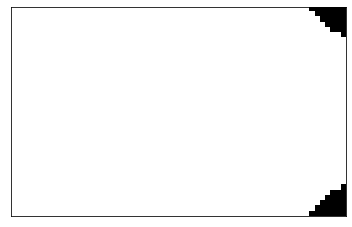

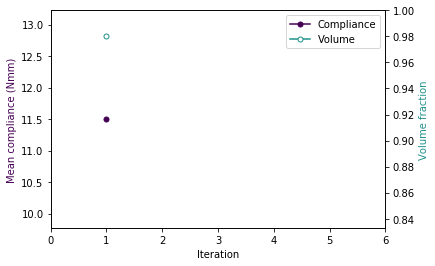

It. 2
Obj.: 11.502441820377113
Vol.: 97.97078124999999 %
ch.: 1


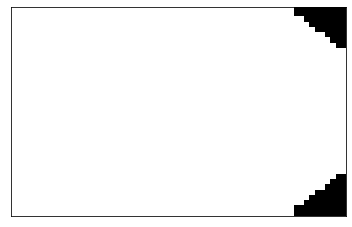

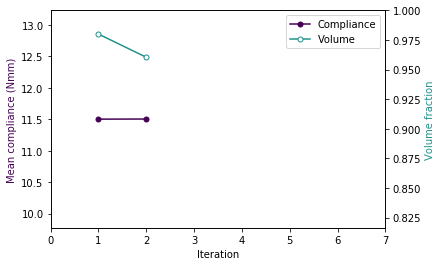

It. 3
Obj.: 11.521088168979176
Vol.: 96.09765625 %
ch.: 1


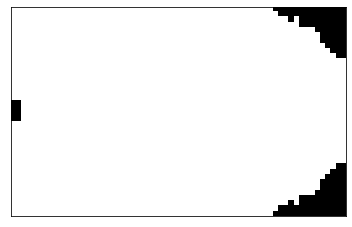

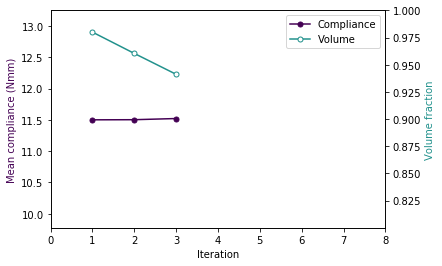

It. 4
Obj.: 11.569562171427432
Vol.: 94.146484375 %
ch.: 1


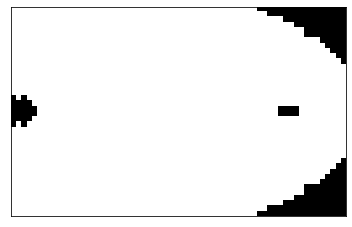

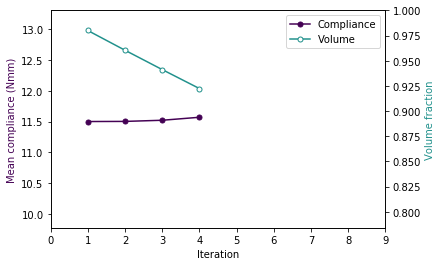

It. 5
Obj.: 11.662042019257786
Vol.: 92.1953125 %
ch.: 1


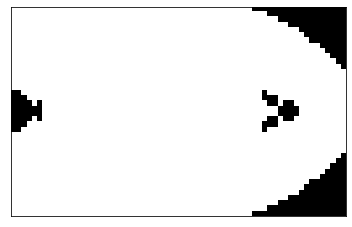

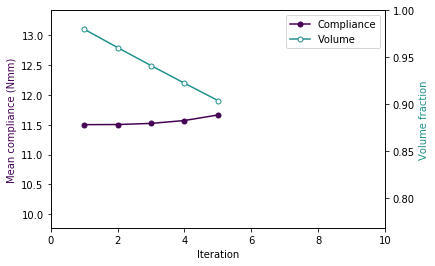

It. 6
Obj.: 11.773546739753597
Vol.: 90.32218750000001 %
ch.: 1


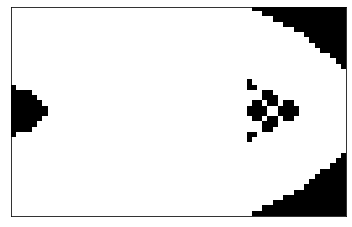

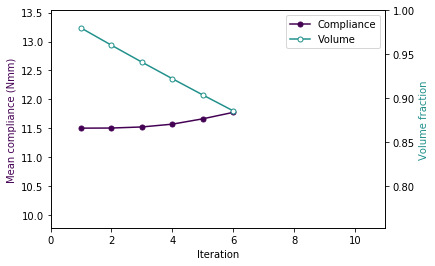

It. 7
Obj.: 11.88474454216146
Vol.: 88.527109375 %
ch.: 1


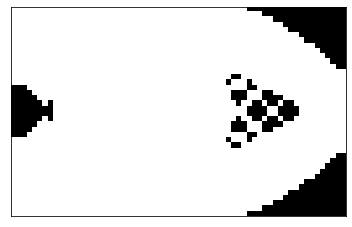

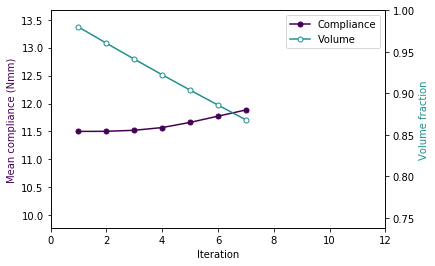

It. 8
Obj.: 12.027149705553907
Vol.: 86.81007812500002 %
ch.: 1


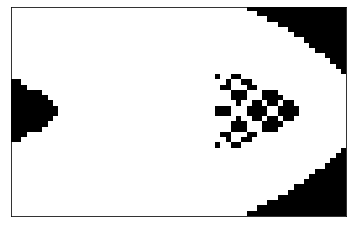

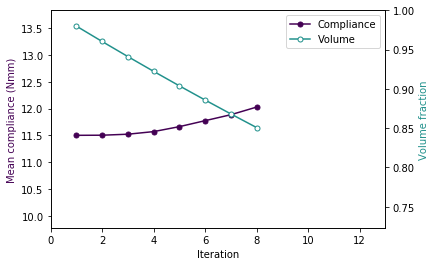

It. 9
Obj.: 12.140830082174302
Vol.: 85.015 %
ch.: 1


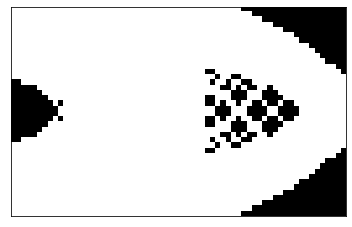

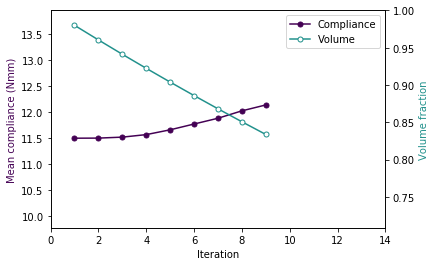

It. 10
Obj.: 12.306294525539682
Vol.: 83.37601562500001 %
ch.: 1


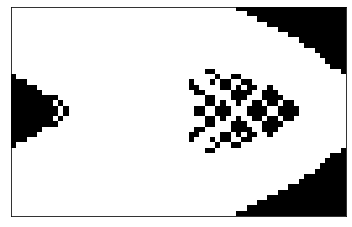

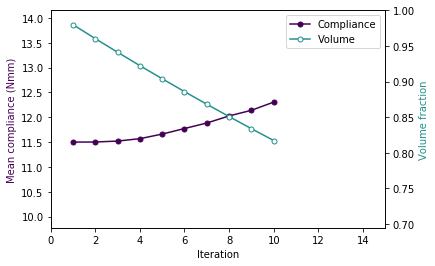

It. 11
Obj.: 12.542882979336651
Vol.: 81.65898437500002 %
ch.: 0.03622948282593185


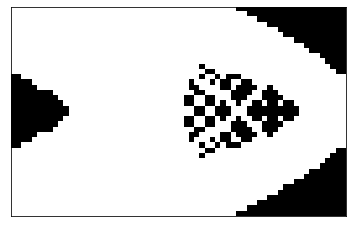

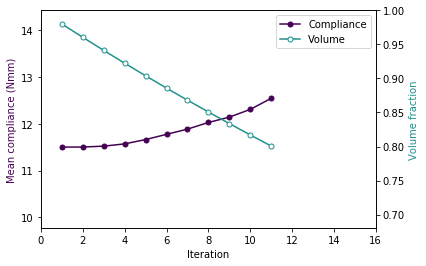

It. 12
Obj.: 12.695533380652147
Vol.: 80.09804687500001 %
ch.: 0.043505528548407245


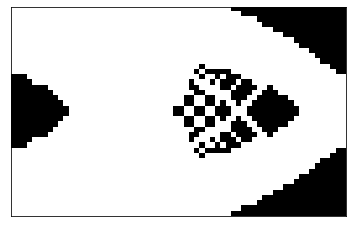

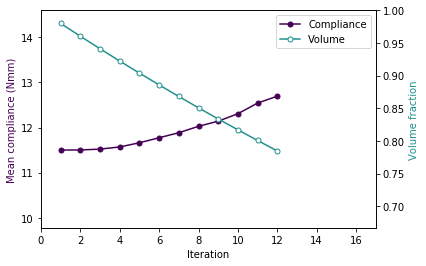

It. 13
Obj.: 12.878361653937896
Vol.: 78.45906250000002 %
ch.: 0.05081727155896021


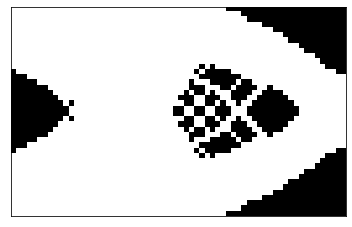

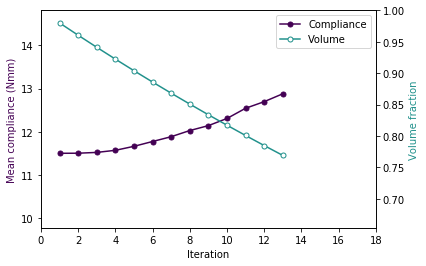

It. 14
Obj.: 13.063058675384864
Vol.: 76.89812500000001 %
ch.: 0.05626678185751798


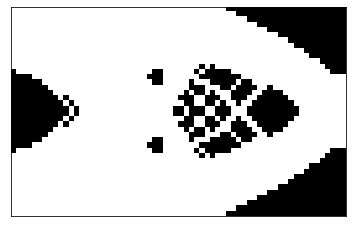

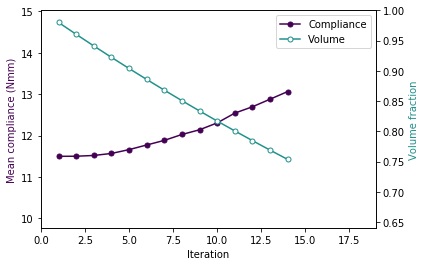

It. 15
Obj.: 13.325283176111485
Vol.: 75.41523437500001 %
ch.: 0.060995678720933734


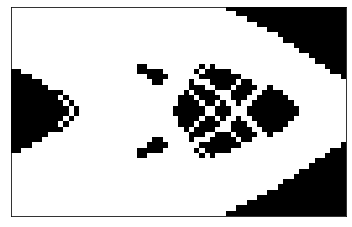

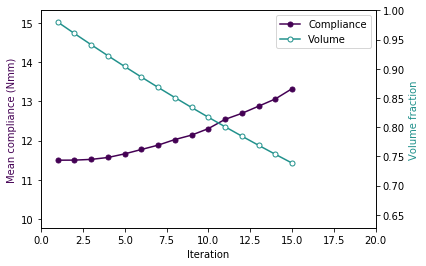

It. 16
Obj.: 13.490043576248567
Vol.: 73.93234375 %
ch.: 0.06552513326734881


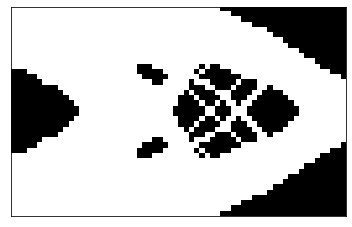

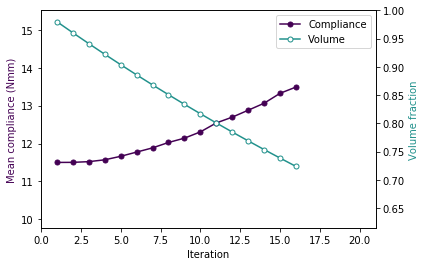

It. 17
Obj.: 13.662358646556015
Vol.: 72.449453125 %
ch.: 0.06934301228325009


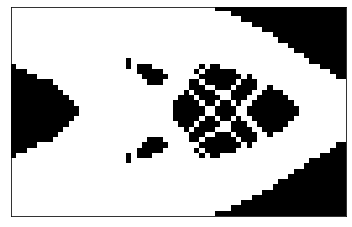

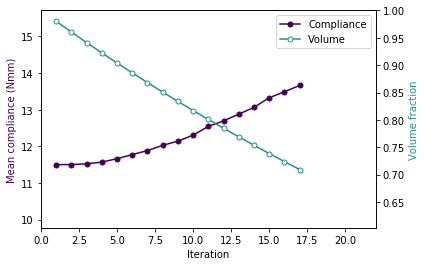

It. 18
Obj.: 14.224084396656567
Vol.: 70.96656250000001 %
ch.: 0.07088363092759097


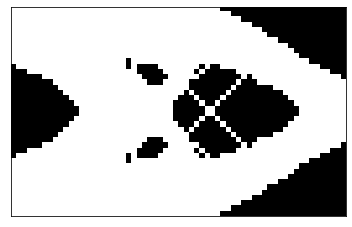

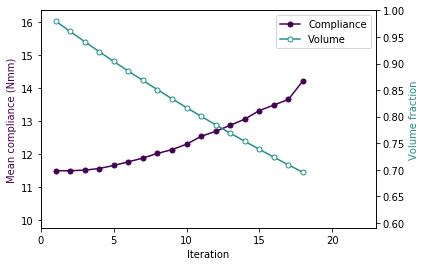

It. 19
Obj.: 14.272850117689732
Vol.: 69.48367187500001 %
ch.: 0.07200503417076372


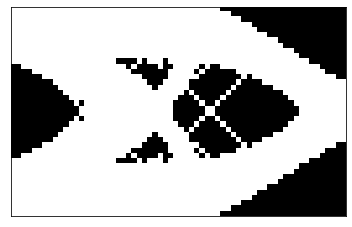

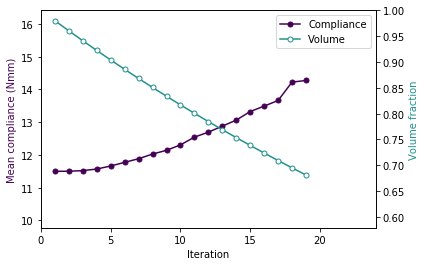

It. 20
Obj.: 14.51430682666827
Vol.: 68.07882812500002 %
ch.: 0.07821862568791253


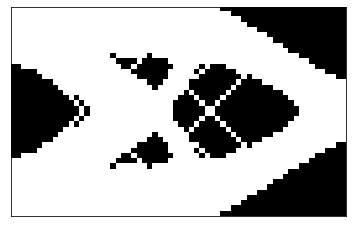

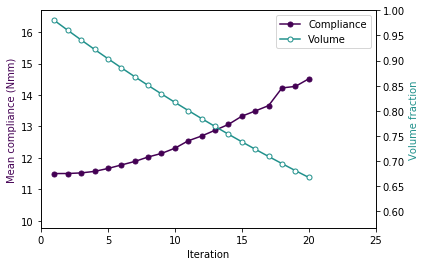

It. 21
Obj.: 14.688043140605288
Vol.: 66.83007812499999 %
ch.: 0.08031542350540775


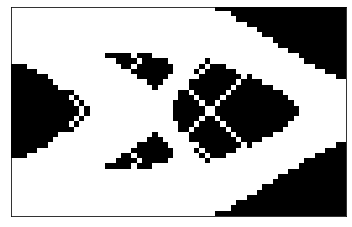

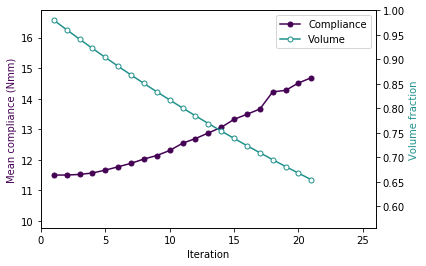

It. 22
Obj.: 15.02358008094022
Vol.: 65.425234375 %
ch.: 0.08313153042188


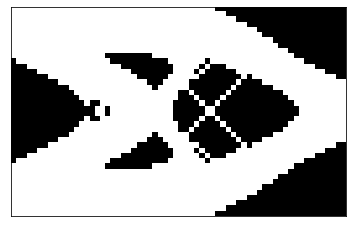

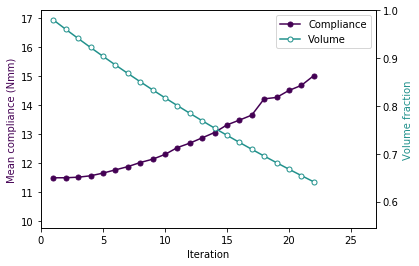

It. 23
Obj.: 15.264173902049343
Vol.: 64.0984375 %
ch.: 0.08566028927986956


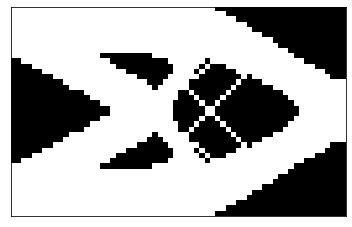

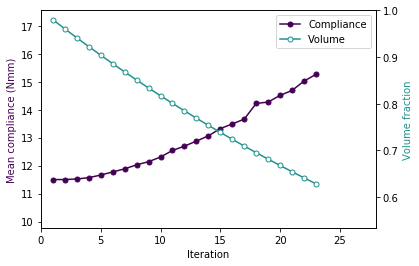

It. 24
Obj.: 15.433540525405434
Vol.: 62.771640625 %
ch.: 0.08475452099242936


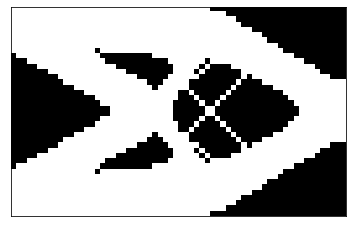

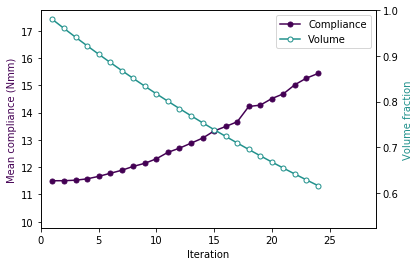

It. 25
Obj.: 15.6479171127901
Vol.: 61.522890625 %
ch.: 0.0804895913225129


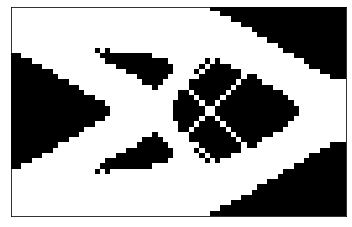

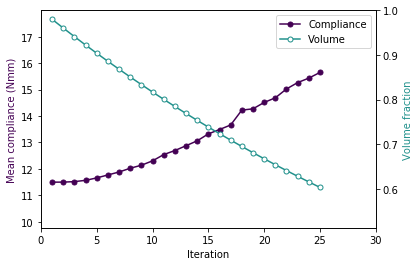

It. 26
Obj.: 15.893051675401436
Vol.: 60.3521875 %
ch.: 0.0787957805382126


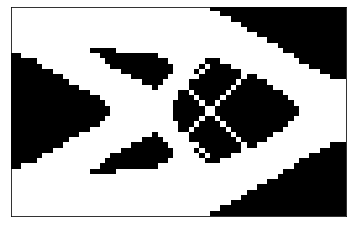

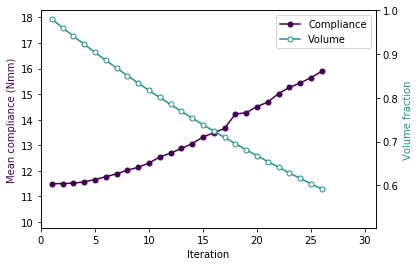

It. 27
Obj.: 16.177610019900555
Vol.: 59.181484375000004 %
ch.: 0.07651412670247773


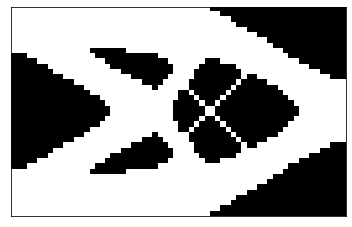

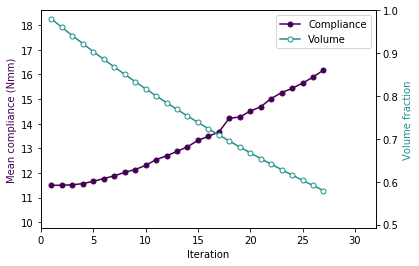

It. 28
Obj.: 16.42883782152809
Vol.: 58.01078125 %
ch.: 0.0729353273477562


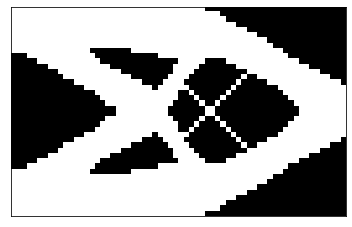

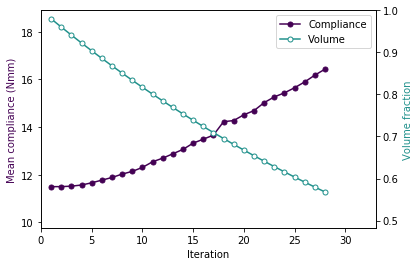

It. 29
Obj.: 16.697110600710115
Vol.: 56.840078125000005 %
ch.: 0.07368460816050175


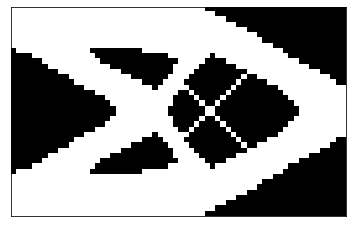

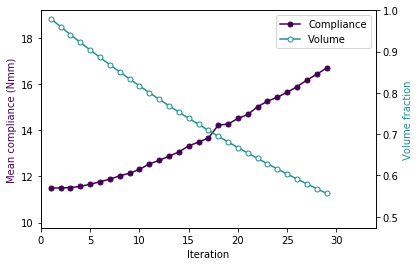

It. 30
Obj.: 16.97644369010797
Vol.: 55.669375 %
ch.: 0.07260327732678389


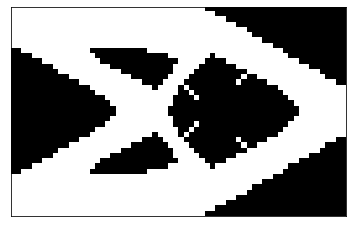

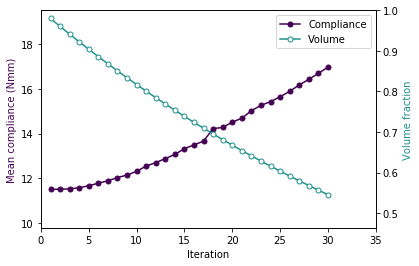

It. 31
Obj.: 17.521715960166517
Vol.: 54.49867187500001 %
ch.: 0.07342824204984197


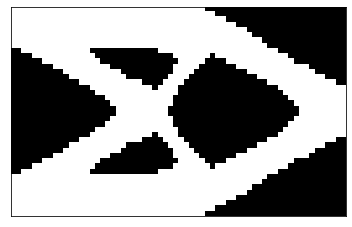

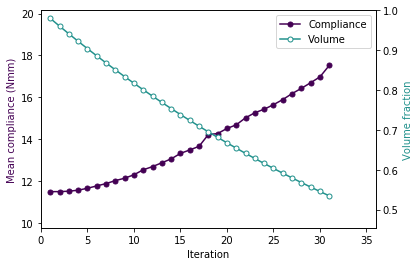

It. 32
Obj.: 17.715509961430282
Vol.: 53.406015625 %
ch.: 0.07409158649788912


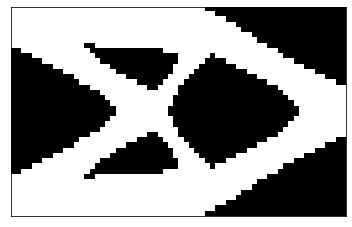

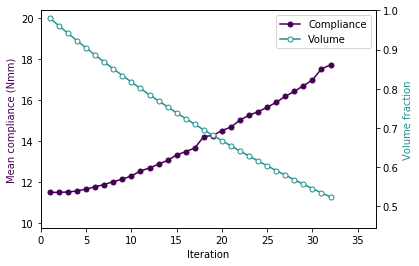

It. 33
Obj.: 17.98992893690108
Vol.: 52.39140625 %
ch.: 0.07963764714044935


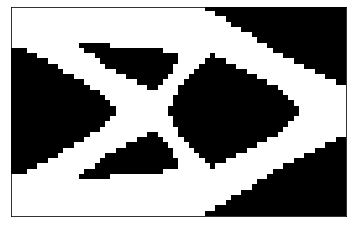

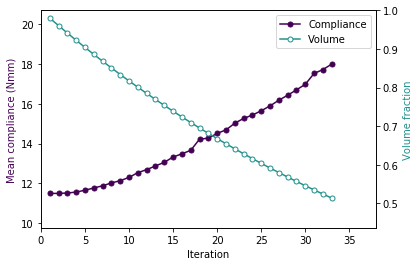

It. 34
Obj.: 18.25090238696277
Vol.: 51.37679687500001 %
ch.: 0.08356690870668583


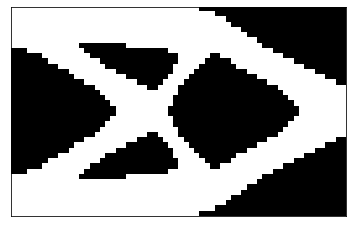

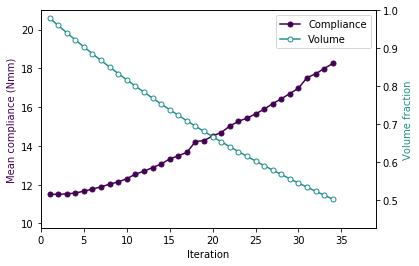

It. 35
Obj.: 18.59997132652131
Vol.: 50.3621875 %
ch.: 0.08626597559372459


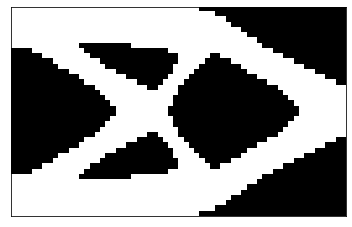

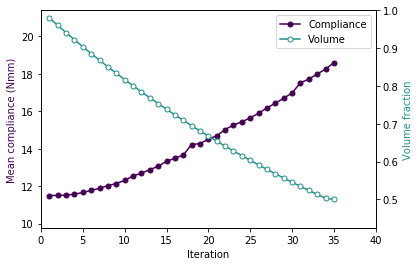

It. 36
Obj.: 18.72669858697279
Vol.: 49.971953125 %
ch.: 0.08787937683238267


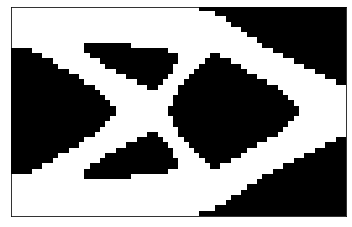

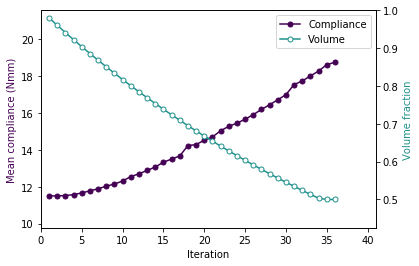

It. 37
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.0865026109188829


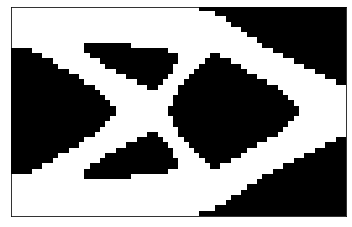

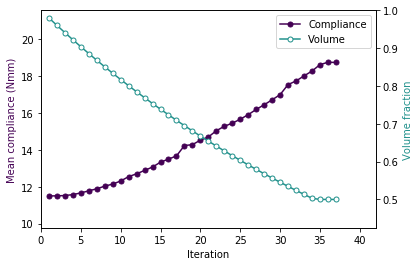

It. 38
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.08078829734436002


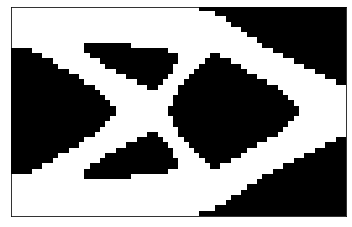

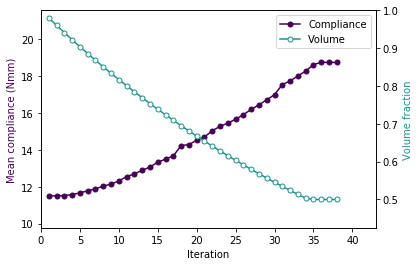

It. 39
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.07250013635643299


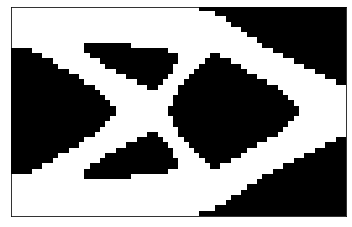

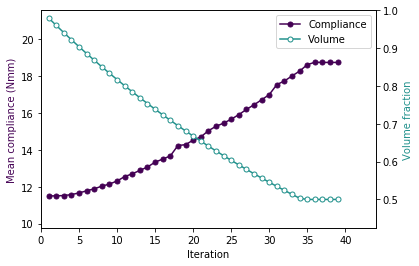

It. 40
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.06102519068586287


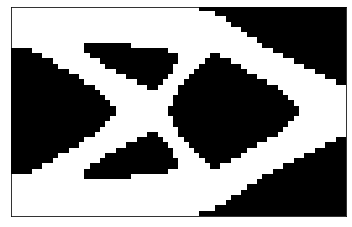

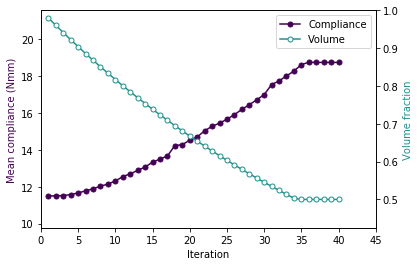

It. 41
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.04550873991979054


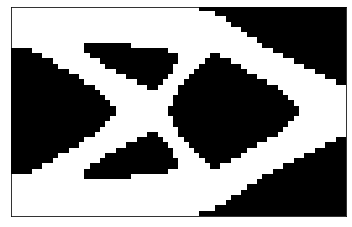

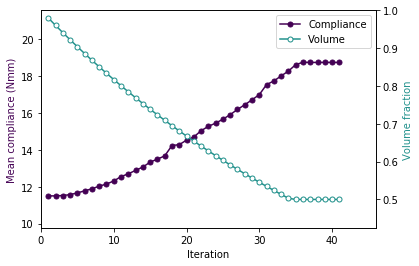

It. 42
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.031020543863644622


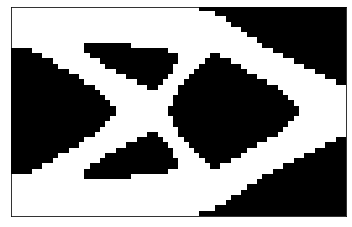

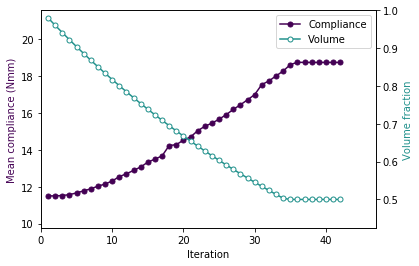

It. 43
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.017516260512427526


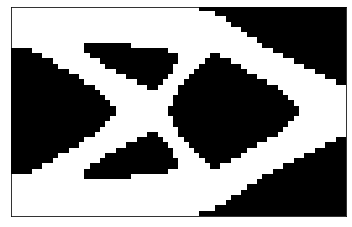

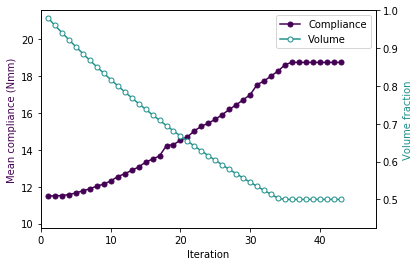

It. 44
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.007769257525555808


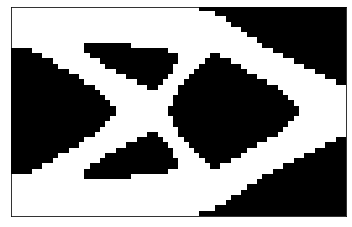

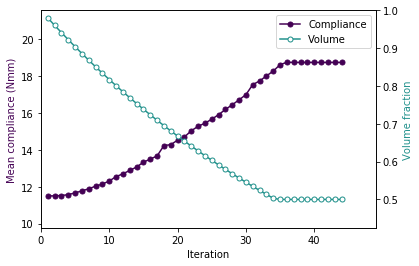

It. 45
Obj.: 18.719775778611883
Vol.: 50.05 %
ch.: 0.0015075186405095308


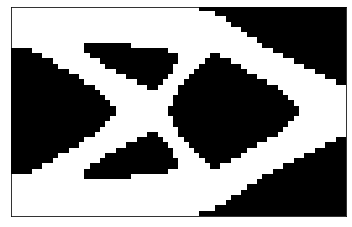

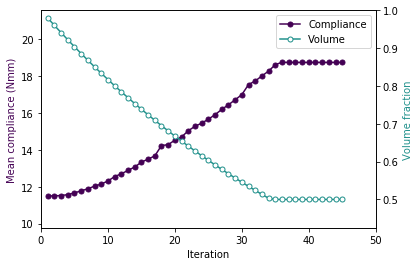


Congratulations! Here it is!
Time cost:  42.387149810791016 seconds.


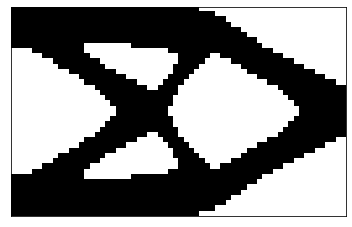

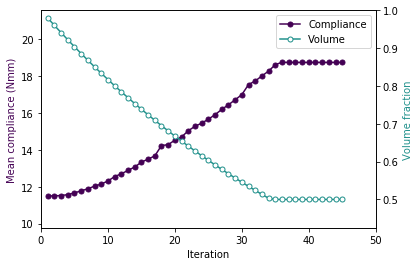

In [51]:
import time
import math

if __name__ == "__main__":
    """
    This is the main program, all necessary parameters are defined here.
    Parameters
    ----------
    E : float
        Young's modulus of the material.
    nu : float
        Poisson ratio of the material.
    nelx : int
        Number of elements in x direction.
    nely : int
        Number of elements in y direction.
    vol_frac : float
        The prescribed total structral volume.
    penal : float
        The penalty exponent.
    rmin : float
        The length of the filter.
    er : float
        The evolutionary rate.
    load : class
        The load applied to the case.
        The following loads are predefined:
        - HalfBeam
        - Beam
        - Cantilever
        - Michell
        - Michell_Onesup
    fesolve : class
        The finite element solver.
        The following fesolvers are predifined:
        - OldFEA(NOT recommended)
        - CvxFEA
    Plotting : bool
        Whether to plot the images every iteration.
    Saving : bool
        Whether to save the final images.
    """
    # Material properties
    E = 1
    nu = 0.3
    
    # Mesh defination
    nelx = 64
    nely = 40
    
    # Optimization parameters
    vol_frac = 0.5
    penal = 3
    rmin = 5.968
    er = 0.02
    
    # Applying load
    load = Cantilever(nelx, nely, E, nu)
    
    # FEA solver
    fesolver = CvxFEA()
    
    # Whether to plot the images every iteration
    Plotting = True
    
    # Whether to save the final images
    Saving = True
    
    # BESO optimization
    optimization = BESO2D(load, fesolver)
    
    # Execute the data
    t = time.time()
    x = np.ones((nely, nelx))
    ke = load.lk(load.E, load.nu)
    u = fesolver.displace(load, x, ke, penal)
    
    # Topology optimization
    optimization.topology(vol_frac, er, rmin, penal, Plotting, Saving)
    
    # Print the time cost
    print('Time cost: ', time.time() - t, 'seconds.')